# REINFORCE Algorithm

In [2]:
%load_ext autoreload
%autoreload 2

https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63

# Instalación de librería gym

https://gym.openai.com/

pip install gym

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gym

# Cart Pole problem

![alt text](cart_pole.gif "Title")

In [15]:
env = gym.make("CartPole-v0")

# REINFORCE. Algoritmo

## 1. Inicializar red neuronal con pesos aleatorios: $\large \pi_{\theta}(a_t|s_t)$
## 2. Correr un episodio y guardar estados ($s_t$), acciones ($a_t$) y rewards ($r_t$)
## 3. Calcular la suma de los discounted rewards:
$$ \huge G_t = \sum_{t'=t+1}^T \gamma^{t'-t-1} r_{t'}$$
## 4. Calcular el gradiente:
$$\huge \nabla_{\theta}J(\theta) = \sum_{t=0}^{T-1}{\nabla_{\theta} log \pi_{\theta}}(a_t|s_t)G_t$$
## 5. Tomar un paso en dirección del gradiente (Queremos maximizar)
$$ \huge \theta = \theta + \alpha \nabla_{\theta}J(\theta) $$
## 6. Repetir desde el paso 2 hasta convergencia

# Toy example

In [203]:
actions = [[1., 0.], [0., 1.], [0, 1], [1, 0]]
pi_outs = [[.9, .1], [.4, .6], [0.2, 0.8], [0.3, 0.7]]
discounted_rewards = [12.24, 11.36, 10.466, 9.56]

In [204]:
import tensorflow as tf
from tensorflow.keras import backend as K
actions = tf.constant(actions, shape=[4,2])
pi = tf.constant(pi_outs, shape=[4,2])
discounted_rewards = tf.constant(discounted_rewards, shape=[4,1])
product = discounted_rewards*actions
loss = K.categorical_crossentropy(product, pi)

In [205]:
actions_np = K.eval(actions)
pi_np = K.eval(pi)
discounted_rewards_np = K.eval(discounted_rewards)
product_np = K.eval(product)
loss_np = K.eval(loss)
print(actions_np)
print(pi_np)
print(discounted_rewards_np)
print(product_np)
print(loss_np)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
[[0.9 0.1]
 [0.4 0.6]
 [0.2 0.8]
 [0.3 0.7]]
[[12.24 ]
 [11.36 ]
 [10.466]
 [ 9.56 ]]
[[12.24   0.   ]
 [ 0.    11.36 ]
 [ 0.    10.466]
 [ 9.56   0.   ]]
[ 1.289613   5.8029785  2.3354201 11.50998  ]


In [206]:
np.log(0.9)*12.24, np.log(0.6)*11.36, np.log(0.8)*10.466, np.log(0.3)*9.56

(-1.2896127116517937,
 -5.802979085981654,
 -2.3354204080545187,
 -11.50998000935595)

# Train full model

In [180]:
from reinforce_alg_helper import plot_episode, actions_to_one_hot, get_policy_model, apply_baselines, discount_rewards, score_model, run_episode, get_observations_stats, get_random_episode, get_batch_data

In [181]:
from keras.layers import Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam
import keras.backend as K
from keras.initializers import glorot_uniform
from keras.losses import categorical_crossentropy, binary_crossentropy

def get_policy_model_softmax(lr=0.1, hidden_layer_neurons = 128, input_shape=[4], output_shape=2):
    model = Sequential()
    model.add(Dense(hidden_layer_neurons, input_shape=input_shape, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(Adam(lr), loss=['categorical_crossentropy'])
    return model

In [182]:
model = get_policy_model_softmax()
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_50 (Dense)             (None, 2)                 258       
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________


In [208]:
states, actions, rewards, reward_sum, discount_rewards, probs = run_episode(env, model, get_probs=True)

In [212]:
print(discount_rewards.T)

[[13.99416454 13.12541872 12.2478977  11.36151283 10.46617457  9.5617925
   8.64827525  7.72553056  6.79346521  5.85198506  4.90099501  3.940399
   2.9701      1.99        1.        ]]


In [213]:
actions.T

array([[0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.]])

In [216]:
np.array(probs)

array([[0.5146247 , 0.48537531],
       [0.3702679 , 0.62973213],
       [0.28568217, 0.71431786],
       [0.21769872, 0.7823013 ],
       [0.16071437, 0.8392857 ],
       [0.19586729, 0.8041327 ],
       [0.23627459, 0.7637254 ],
       [0.17352705, 0.82647294],
       [0.20755921, 0.79244083],
       [0.24649705, 0.7535029 ],
       [0.29383373, 0.7061662 ],
       [0.21711956, 0.7828805 ],
       [0.25664   , 0.74336   ],
       [0.18769014, 0.81230986],
       [0.2212232 , 0.77877676]], dtype=float32)

In [217]:
actions_to_one_hot(actions)*discount_rewards

array([[13.99416454,  0.        ],
       [13.12541872,  0.        ],
       [12.2478977 ,  0.        ],
       [11.36151283,  0.        ],
       [ 0.        , 10.46617457],
       [ 0.        ,  9.5617925 ],
       [ 8.64827525,  0.        ],
       [ 0.        ,  7.72553056],
       [ 0.        ,  6.79346521],
       [ 0.        ,  5.85198506],
       [ 4.90099501,  0.        ],
       [ 0.        ,  3.940399  ],
       [ 2.9701    ,  0.        ],
       [ 0.        ,  1.99      ],
       [ 0.        ,  1.        ]])

In [218]:
states

array([[ 0.02938542, -0.04696576,  0.0367114 , -0.04724441],
       [ 0.02844611, -0.24259437,  0.03576651,  0.25679152],
       [ 0.02359422, -0.43820823,  0.04090234,  0.56053775],
       [ 0.01483006, -0.63387965,  0.0521131 ,  0.86582134],
       [ 0.00215246, -0.82967066,  0.06942952,  1.17442346],
       [-0.01444095, -0.63551625,  0.09291799,  0.90428939],
       [-0.02715128, -0.44176725,  0.11100378,  0.64219817],
       [-0.03598662, -0.63824712,  0.12384774,  0.96767222],
       [-0.04875156, -0.44498616,  0.14320119,  0.71631939],
       [-0.05765129, -0.25210596,  0.15752758,  0.47191791],
       [-0.06269341, -0.05951871,  0.16696593,  0.23273572],
       [-0.06388378, -0.25658391,  0.17162065,  0.57308302],
       [-0.06901546, -0.06423098,  0.18308231,  0.33900147],
       [-0.07030008, -0.26142165,  0.18986234,  0.68337006],
       [-0.07552851, -0.06937215,  0.20352974,  0.45595722]])

In [219]:
model.fit(states, actions_to_one_hot(actions)*discount_rewards)

Epoch 1/1
15/15 [==============================] - 0s 977us/step - loss: 5.8519


In [220]:
goal = 200
epsilon=1e-12
model = get_policy_model_softmax(lr=0.001)
print_every = 10
for num_episode in range(1000):
    states, actions, rewards, reward_sum, discount_rewards, probs = run_episode(env, model, get_probs=True)
    probs = np.array(probs)
    history = model.fit(states, actions_to_one_hot(actions)*discount_rewards, verbose=0)
    loss = history.history['loss'][0]
    score = score_model(model, env, 10)
    entropy = np.mean(-np.sum(np.log(probs+epsilon)*probs, axis=1)/np.log(2))
    if (num_episode%print_every) == 0:
        print(f'{num_episode}) episode length: {len(states)} loss: {loss:.3f}, score: {score}, entropy: {entropy:.3f}')
    if score>=goal:
        print(f'Goal Reached in {num_episode} episodes! Final score:', score)
        break

0) episode length: 17 loss: 5.791, score: 9.3, entropy: 0.984
10) episode length: 30 loss: 10.003, score: 9.6, entropy: 0.999
20) episode length: 20 loss: 7.048, score: 9.6, entropy: 0.975
30) episode length: 46 loss: 14.829, score: 8.9, entropy: 0.990
40) episode length: 36 loss: 11.704, score: 9.6, entropy: 0.999
50) episode length: 30 loss: 9.865, score: 10.7, entropy: 1.000
60) episode length: 13 loss: 4.541, score: 9.3, entropy: 0.990
70) episode length: 18 loss: 6.194, score: 9.2, entropy: 0.998
80) episode length: 12 loss: 4.473, score: 36.5, entropy: 0.999
90) episode length: 29 loss: 9.356, score: 46.3, entropy: 0.999
100) episode length: 58 loss: 16.906, score: 45.2, entropy: 0.996
110) episode length: 41 loss: 12.625, score: 47.7, entropy: 0.993
120) episode length: 13 loss: 4.870, score: 57.2, entropy: 0.992
130) episode length: 14 loss: 4.966, score: 44.2, entropy: 0.998
140) episode length: 23 loss: 7.989, score: 39.8, entropy: 0.968
150) episode length: 9 loss: 4.149, sc

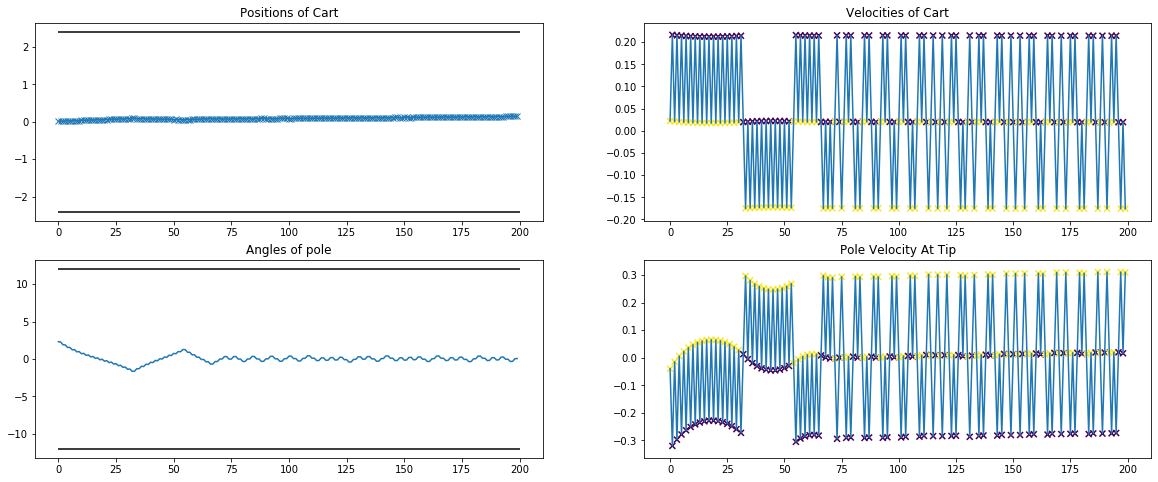

In [221]:
states, actions, rewards, reward_sum, discounted_rewards = run_episode(env, model, greedy=True)
plot_episode(*states.T, actions, show_pos_thres=True)

Media de las acciones [0,1]: 0.4997133565692079
Media de rewards: 197.109


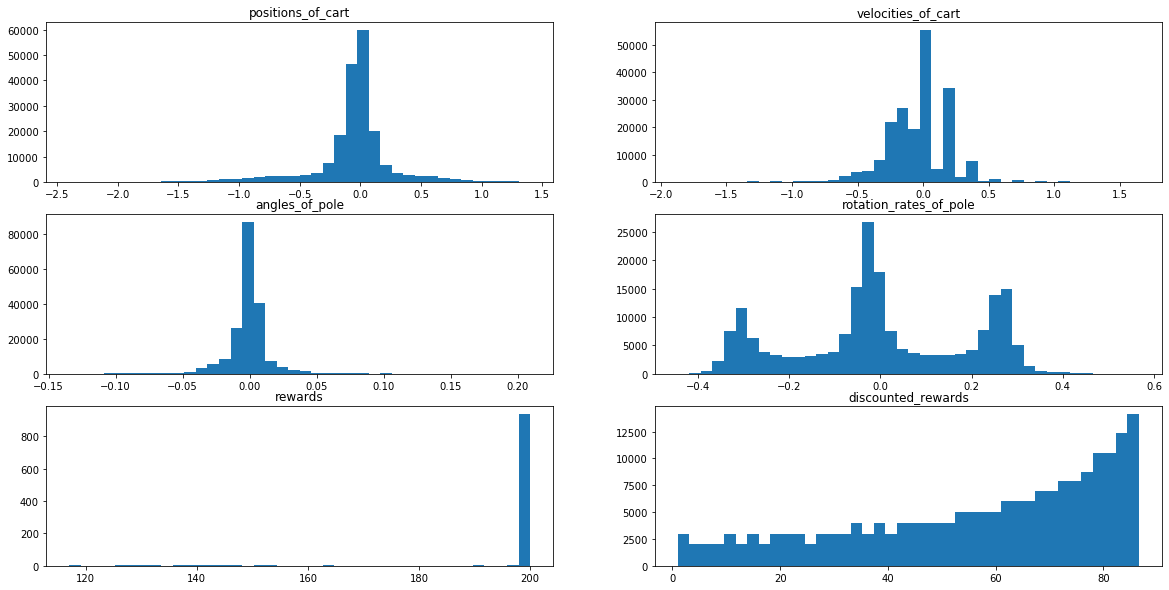

CPU times: user 2min 8s, sys: 6.16 s, total: 2min 14s
Wall time: 1min 28s


In [224]:
%time states_means, states_stds = get_observations_stats(env, lambda env: run_episode(env, model, greedy=True), N=1000)

Media de las acciones [0,1]: 0.5080204981527827
Media de rewards: 125.865


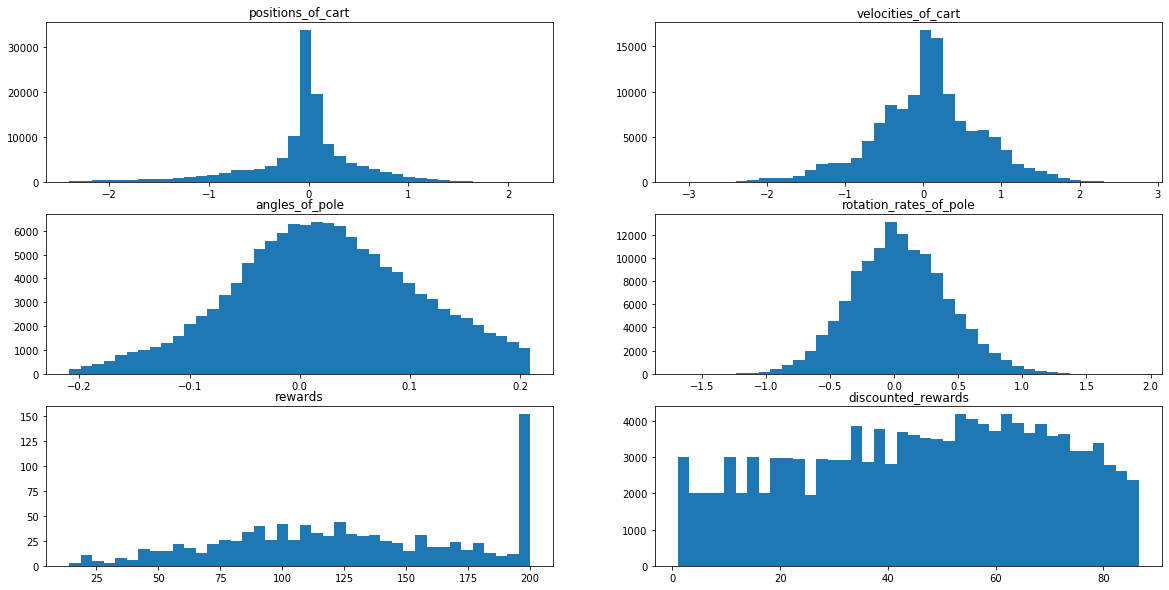

CPU times: user 1min 39s, sys: 4.56 s, total: 1min 43s
Wall time: 1min 6s


In [225]:
%time states_means, states_stds = get_observations_stats(env, lambda env: run_episode(env, model, greedy=False), N=1000)

# Con batches

In [122]:
def train_full_model(lr=0.1, max_num_episodes = 10000, episodes_batch_size = 50, training_epochs = 1, goal = 200, 
                     reset_model=True, hidden_layer_neurons = 128, verbose_period = 2, 
                     score_thres=10, states_means=None, states_stds=None,
                     model_train=None, model_predict=None, epsilon=1e-12):
    losses=[]
    if model_train is None:
        # Get model
        model_train, model_predict = get_policy_model(env, hidden_layer_neurons, lr)
    num_episode = 0
    i = 0
    
    while num_episode < max_num_episodes:
        # Get batch_size episodes for training
        batch_states, batch_actions, discounted_rewards, batch_probs = get_batch_data(env, model_predict, episodes_batch_size)
        if states_means is not None:
            batch_states = (batch_states - states_means)/states_stds
        # format data for NN
        discounted_rewards = apply_baselines(discounted_rewards)
        # discounted_rewards = np.ones((len(batch_actions), 1))*len(batch_states)/episodes_batch_size
        actions_train = actions_to_one_hot(batch_actions)
        hist = model_train.fit([batch_states, discounted_rewards], actions_train, 
                               batch_size=len(batch_states),
                               epochs=training_epochs, verbose=0)
        loss = hist.history['loss'][0]
        losses.append(loss)
        score = score_model(model_predict, env, score_thres)
        if (i%verbose_period) == 0:
            entropy = np.mean(-np.sum(np.log(batch_probs+epsilon)*batch_probs, axis=1)/np.log(2))
            print(f'{num_episode}) episode avg_len: {len(batch_states)/episodes_batch_size} loss: {loss:.3f}, score: {score}, entropy: {entropy:.3f}')
            # print(num_episode, np.mean(losses), score, entropy)
        if score >= goal:
            print("Solved in {} episodes!".format(num_episode))
            break
        num_episode+=episodes_batch_size
        i+=1
    return losses, model_train, model_predict

In [123]:
losses, model_train, model_predict = train_full_model(lr=0.001, training_epochs = 1, hidden_layer_neurons = 128, 
                                                      episodes_batch_size=1, max_num_episodes=10000, 
                                                      score_thres = 10, 
                                                      verbose_period = 10,
                                                      #states_means=states_means, states_stds=states_stds,
                                                      model_train=None, model_predict=None)
#                                                       model_train=model_train, model_predict=model_predict)

0) episode avg_len: 31.0 loss: 0.01, score: 9.0, entropy: 0.999
10) episode avg_len: 18.0 loss: 0.00, score: 17.4, entropy: 1.000
20) episode avg_len: 53.0 loss: -0.01, score: 33.6, entropy: 0.998
30) episode avg_len: 20.0 loss: 0.00, score: 46.6, entropy: 1.000
40) episode avg_len: 20.0 loss: -0.00, score: 40.6, entropy: 0.994
50) episode avg_len: 15.0 loss: -0.00, score: 26.7, entropy: 1.000
60) episode avg_len: 15.0 loss: 0.00, score: 18.4, entropy: 0.997
70) episode avg_len: 9.0 loss: 0.00, score: 35.7, entropy: 1.000
80) episode avg_len: 28.0 loss: -0.01, score: 48.3, entropy: 0.998
90) episode avg_len: 34.0 loss: 0.00, score: 66.6, entropy: 0.998
100) episode avg_len: 20.0 loss: -0.01, score: 108.4, entropy: 0.994
110) episode avg_len: 24.0 loss: -0.03, score: 96.1, entropy: 0.997
120) episode avg_len: 17.0 loss: -0.04, score: 122.8, entropy: 0.995
130) episode avg_len: 55.0 loss: 0.01, score: 118.5, entropy: 0.996
140) episode avg_len: 11.0 loss: -0.00, score: 73.6, entropy: 0.9

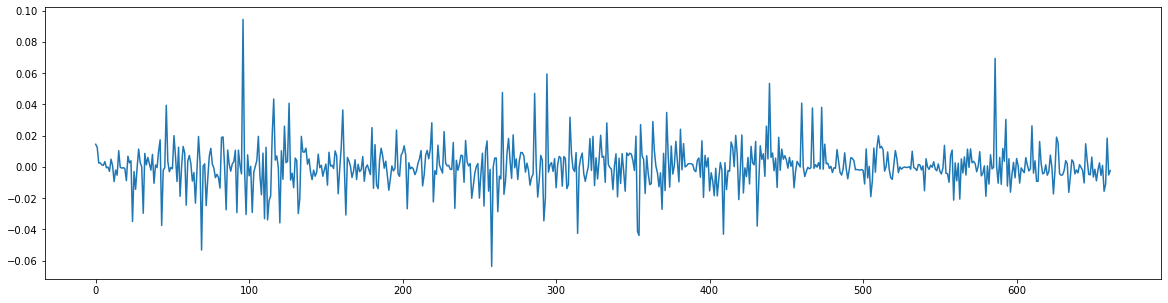

In [124]:
plt.figure(figsize=(20,5))
plt.plot(losses)

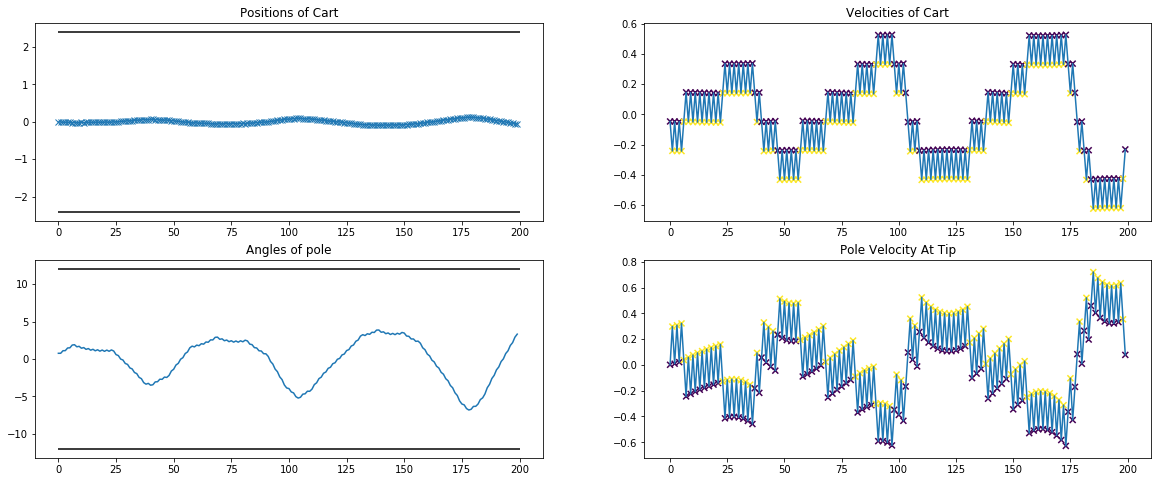

In [131]:
states, actions, rewards, reward_sum, discounted_rewards = run_episode(env, model_predict, greedy=True)
plot_episode(*states.T, actions, show_pos_thres=True)

Media de las acciones [0,1]: 0.5107660797815315
Media de rewards: 187.487


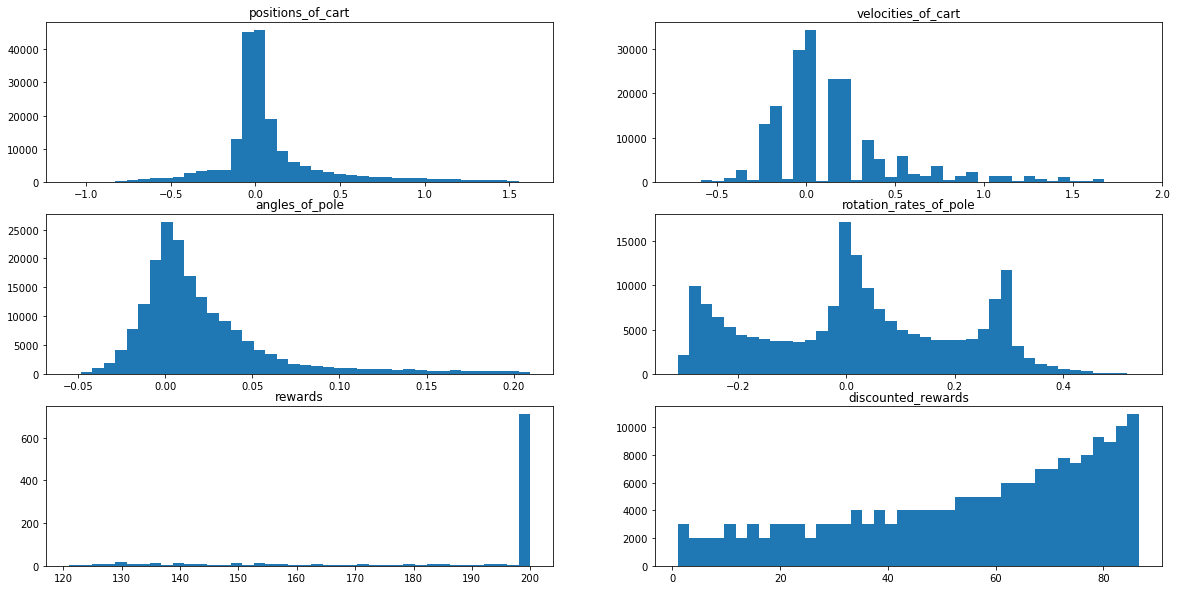

CPU times: user 1min 37s, sys: 5.16 s, total: 1min 42s
Wall time: 1min 4s


In [84]:
%time states_means, states_stds = get_observations_stats(env, lambda env: run_episode(env, model_predict, greedy=True), N=1000)

Media de las acciones [0,1]: 0.45356229165051554
Media de rewards: 25.798


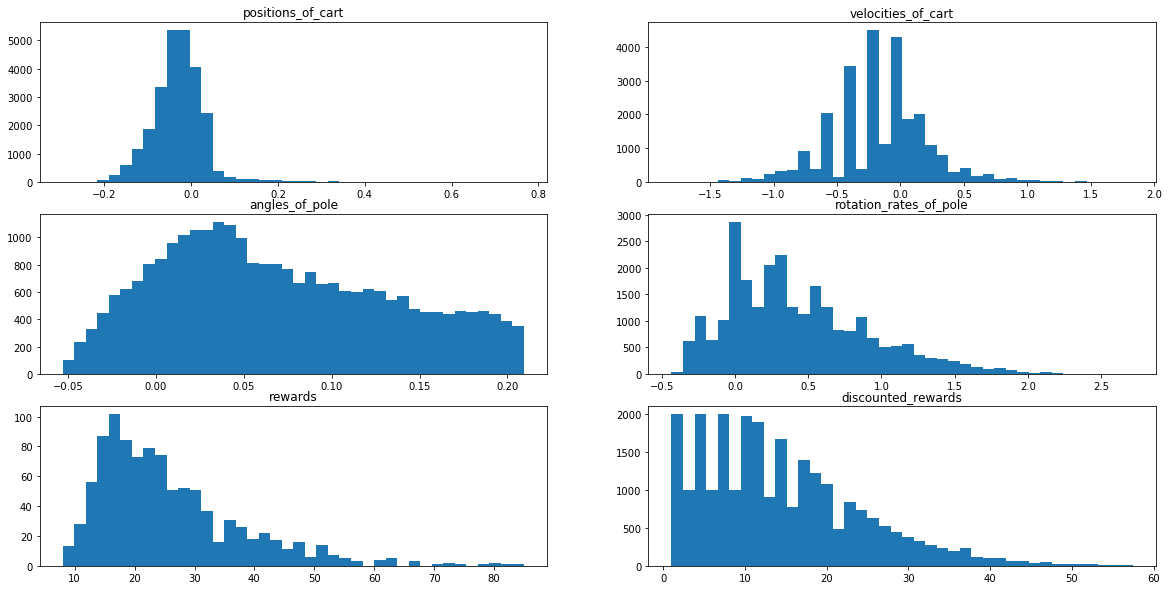

CPU times: user 15.6 s, sys: 826 ms, total: 16.5 s
Wall time: 11 s


In [85]:
%time states_means, states_stds = get_observations_stats(env, lambda env: run_episode(env, model_predict, greedy=False), N=1000)

In [177]:
# model_predict.save('model_predict-lr_0.005-training_epochs_1-hidden_layer_neurons_128-batch_size_50.hdf5')
# model_train.save('model_train-lr_0.005-training_epochs_1-hidden_layer_neurons_128-batch_size_50.hdf5')

In [296]:
print_every

100

In [347]:
training_episodes = 1
reward_sum = 0
model_train, model_predict = get_policy_model(env, hidden_layer_neurons, 0.01)
num_actions = env.action_space.n

# Placeholders for our observations, outputs and rewards
states = np.empty(0).reshape(0,dimen)
actions = np.empty(0).reshape(0,1)
rewards = np.empty(0).reshape(0,1)
discounted_rewards = np.empty(0).reshape(0,1)

# Setting up our environment
observation = env.reset()

num_episode = 0

losses = []

while num_episode < num_episodes:
    # Append the observations to our batch
    state = np.reshape(observation, [1, dimen])
    
    predict = model_predict.predict([state])[0]
    action = np.random.choice(range(num_actions),p=predict)
    
    # Append the observations and outputs for learning
    states = np.vstack([states, state])
    actions = np.vstack([actions, action])
    
    # Determine the oucome of our action
    observation, reward, done, _ = env.step(action)
    reward_sum += reward
    rewards = np.vstack([rewards, reward])
    
    if done:
        # Determine standardized rewards
        discounted_rewards_episode = discount_rewards(rewards, gamma)       
        discounted_rewards = np.vstack([discounted_rewards, discounted_rewards_episode])
        
        rewards = np.empty(0).reshape(0,1)

        if (num_episode + 1) % batch_size == 0:
            discounted_rewards -= discounted_rewards.mean()
            discounted_rewards /= discounted_rewards.std()
            discounted_rewards = discounted_rewards.squeeze()
            actions = actions.squeeze().astype(int)
           
            actions_train = np.zeros([len(actions), num_actions])
            actions_train[np.arange(len(actions)), actions] = 1
            for i in range(training_episodes):
                loss = model_train.train_on_batch([states, discounted_rewards], actions_train)
            losses.append(loss)

            # Clear out game variables
            states = np.empty(0).reshape(0,dimen)
            actions = np.empty(0).reshape(0,1)
            discounted_rewards = np.empty(0).reshape(0,1)


        # Print periodically
        if (num_episode + 1) % print_every == 0:
            # Print status
            score = score_model(model_predict,10)
            print("Average reward for training episode {}: {:0.2f} Test Score: {:0.2f} Loss: {:0.6f}".format(
                (num_episode + 1), reward_sum/print_every, 
                score,
                np.mean(losses[-print_every:],)
            ))
            
            if score >= goal:
                print("Solved in {} episodes!".format(num_episode))
                break
            reward_sum = 0
                
        num_episode += 1
        observation = env.reset()
        

Average reward for training episode 100: 21.01 Test Score: 10.70 Loss: 0.038741
Average reward for training episode 200: 24.74 Test Score: 9.90 Loss: 0.026502
Average reward for training episode 300: 23.58 Test Score: 10.40 Loss: 0.018445
Average reward for training episode 400: 21.59 Test Score: 128.10 Loss: 0.013997
Average reward for training episode 500: 24.43 Test Score: 164.70 Loss: 0.010653
Average reward for training episode 600: 24.76 Test Score: 120.80 Loss: 0.007927
Average reward for training episode 700: 24.56 Test Score: 137.90 Loss: 0.006454
Average reward for training episode 800: 27.15 Test Score: 129.50 Loss: 0.005687
Average reward for training episode 900: 27.19 Test Score: 130.60 Loss: 0.004652
Average reward for training episode 1000: 26.31 Test Score: 111.80 Loss: 0.003936
Average reward for training episode 1100: 32.67 Test Score: 111.80 Loss: 0.003302
Average reward for training episode 1200: 28.12 Test Score: 110.20 Loss: 0.002945
Average reward for training e

KeyboardInterrupt: 

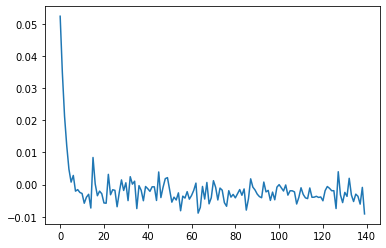

In [289]:
plt.plot(losses)

In [ ]:
env.close()